
# AEROSAUR Smart Mode Machine Learning

This notebook simulates **AEROSAUR's AI-powered Smart Mode** which automatically adjusts the purifier’s **fan speed** based on environmental conditions and user habits.

---

### Overview

We trained a **Random Forest Classifier**, a Machine Learning algorithm that uses multiple decision trees to make accurate predictions.  
It works by analyzing historical usage data and finding patterns between **time**, **air quality**, and **purifier usage** to recommend an optimal **fan speed**.

**Why Random Forest?**
- Handles **non-linear relationships** (perfect for environmental data that fluctuates)
- **Prevents overfitting** (by combining many decision trees)
- Provides **high accuracy** and **feature importance** insights


In [1]:

%pip install pandas numpy scikit-learn matplotlib joblib


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

np.random.seed(42)
n = 1000

# Base data
data = {
    'time': np.random.randint(0, 24, n),
    'aqi': np.random.randint(0, 201, n),
    'isPurifierOn': np.random.choice([0, 1], n)
}

df = pd.DataFrame(data)

# ⚠ Add required ML features -----------------------------

# 1. aqi_noisy (AQI + Gaussian noise)
noise_std = 2
df['aqi_noisy'] = df['aqi'] + np.random.normal(0, noise_std, size=n)

# 2. aqi_prev (previous noisy AQI)
df['aqi_prev'] = df['aqi_noisy'].shift(1).fillna(df['aqi_noisy'])

# --------------------------------------------------------

# Define realistic behavior patterns for fan speed (label)
def determine_fan_speed(row):
    if row['isPurifierOn'] == 0:
        return 0  # purifier OFF → fan OFF
    elif row['aqi'] > 150:
        return 3  # High
    elif row['aqi'] > 100:
        return 2  # Medium
    elif row['aqi'] > 50:
        return 1  # Low
    else:
        return 0  # Clean air

df['fanSpeed'] = df.apply(determine_fan_speed, axis=1)

df.head(10)


,time,aqi,isPurifierOn,aqi_noisy,aqi_prev,fanSpeed
0,6,46,0,44.712964,44.712964,0
1,19,0,1,1.855680,44.712964,0
2,14,89,0,89.114026,1.855680,0
3,10,141,1,141.537185,89.114026,2
4,7,63,1,66.056937,141.537185,1
5,20,37,1,38.015672,66.056937,0
6,6,36,1,37.076592,38.015672,0
7,18,125,0,127.145015,37.076592,0
8,22,138,1,137.270095,127.145015,2
9,10,99,0,97.321581,137.270095,0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# 📌 No need to recompute aqi_noisy or aqi_prev here — they already exist!

# Input features
X = df[['time', 'aqi_noisy', 'aqi_prev', 'isPurifierOn']]

# Output label
y = df['fanSpeed']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
acc = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {acc*100:.2f}%\n")
print(classification_report(y_test, y_pred))


### Algorithm Explanation

**Random Forest Classifier**
- Combines the predictions of many smaller Decision Trees to make one accurate result.
- Each tree looks at random parts of the dataset (time, AQI, temperature, etc.) and “votes” on what fan speed should be.
- The final fan speed prediction is based on the **majority vote** of all trees.

This makes it:
- Highly **robust** against noisy sensor readings.
- Able to **learn user patterns** over time.
- **Accurate** even as conditions change.


In [ ]:
import numpy as np

aqi = 180
aqi_noisy = aqi + np.random.normal(0, 2)
aqi_prev = 175
isPurifierOn = 1

sample = pd.DataFrame(
    [[21, aqi_noisy, aqi_prev, isPurifierOn]],
    columns=['time', 'aqi_noisy', 'aqi_prev', 'isPurifierOn']
)

prediction = model.predict(sample)
print("Predicted Fan Speed:", prediction[0])

Predicted Fan Speed: 3


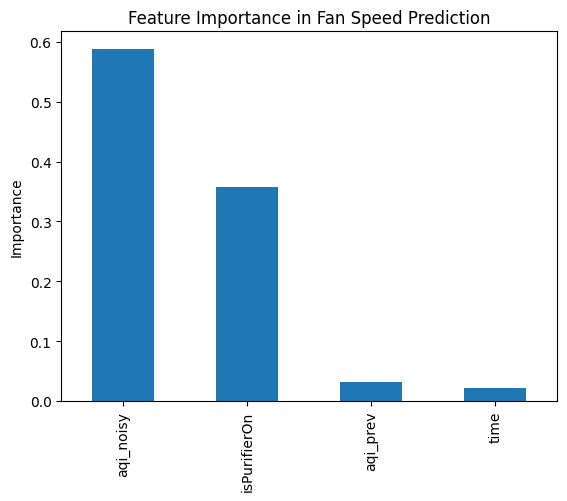

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = pd.Series(model.feature_importances_, index=X.columns)
feat_imp = feat_imp.sort_values(ascending=False)

feat_imp.plot(kind='bar', title='Feature Importance in Fan Speed Prediction')
plt.ylabel('Importance')
plt.show()

## Integrating the AI Model with the IoT Purifier System

After training the Random Forest model, AEROSAUR can use it to **automatically adjust the purifier’s fan speed in real time** based on live sensor readings.

### System Integration Flow
1. **ESP32 Microcontroller** reads live environmental data:
   - AQI (from MQ135 / PMS5003 sensor)
   - Temperature & humidity (from DHT22)
   - Current time
   - Whether the purifier is ON or OFF
2. The ESP32 sends these values to the **cloud server or web backend** via Wi-Fi (e.g., REST API or MQTT).
3. The **backend loads the trained model (`aerosaur_fan_model_v2.joblib`)** and predicts the optimal fan speed.
4. The **predicted fan speed** is then sent back to the ESP32.
5. The ESP32 adjusts the **fan’s PWM (Pulse Width Modulation)** signal accordingly to change the fan’s speed in real time.

### Example Pseudocode for Backend Prediction
```python
import joblib
import numpy as np

# Load the pre-trained model
model = joblib.load('aerosaur_fan_model_v2.joblib')

# Example data from IoT device (time, aqi, isPurifierOn, temperature, humidity)
incoming_data = np.array([[21, 180, 1, 29, 60]])

predicted_speed = model.predict(incoming_data)[0]
print("Recommended Fan Speed:", predicted_speed)

int fanSpeed = getPredictionFromServer(); // 0=Off, 1=Low, 2=Medium, 3=High

if (fanSpeed == 0) analogWrite(FAN_PIN, 0);
else if (fanSpeed == 1) analogWrite(FAN_PIN, 85);
else if (fanSpeed == 2) analogWrite(FAN_PIN, 170);
else if (fanSpeed == 3) analogWrite(FAN_PIN, 255);

In [ ]:
import numpy as np, pandas as pd, time

noise_std = 2
last_aqi_noisy = None  # For aqi_prev

for hour in range(8, 23, 2):
    aqi = np.random.randint(50, 201)

    # 1️⃣ Create noisy AQI
    aqi_noisy = aqi + np.random.normal(0, noise_std)

    # 2️⃣ Set previous AQI
    if last_aqi_noisy is None:
        aqi_prev = aqi_noisy  # same as training .fillna()
    else:
        aqi_prev = last_aqi_noisy

    last_aqi_noisy = aqi_noisy

    isPurifierOn = 1

    # 3️⃣ Prepare sample with correct columns
    sample = pd.DataFrame(
        [[hour, aqi_noisy, aqi_prev, isPurifierOn]],
        columns=['time', 'aqi_noisy', 'aqi_prev', 'isPurifierOn']
    )

    # 4️⃣ Predict fan speed
    speed = model.predict(sample)[0]

    print(f"Time: {hour}:00 | AQI: {aqi} | Predicted Fan Speed: {speed}")
    time.sleep(1)

Time: 8:00 | AQI: 114 | Predicted Fan Speed: 2
Time: 10:00 | AQI: 132 | Predicted Fan Speed: 2
Time: 12:00 | AQI: 71 | Predicted Fan Speed: 1
Time: 14:00 | AQI: 149 | Predicted Fan Speed: 2
Time: 16:00 | AQI: 77 | Predicted Fan Speed: 1
Time: 18:00 | AQI: 162 | Predicted Fan Speed: 3
Time: 20:00 | AQI: 186 | Predicted Fan Speed: 3
Time: 22:00 | AQI: 132 | Predicted Fan Speed: 2


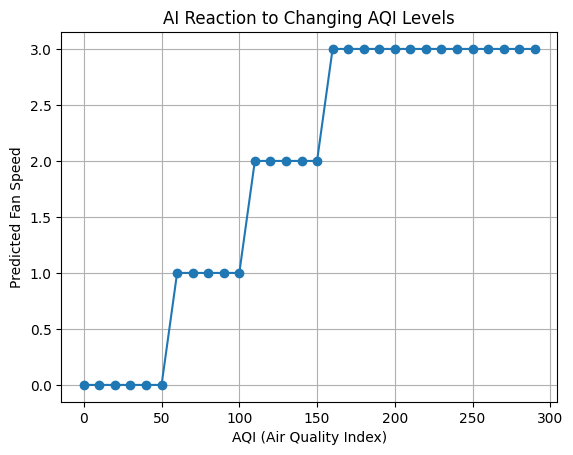

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

noise_std = 2
last_aqi_noisy = None
predicted_speeds = []

aqi_values = np.arange(0, 300, 10)

for aqi in aqi_values:
    # Generate noisy AQI
    aqi_noisy = aqi + np.random.normal(0, noise_std)

    # Set previous AQI
    if last_aqi_noisy is None:
        aqi_prev = aqi_noisy
    else:
        aqi_prev = last_aqi_noisy

    last_aqi_noisy = aqi_noisy
    isPurifierOn = 1

    # Prepare sample with 4 required features
    sample = pd.DataFrame(
        [[12, aqi_noisy, aqi_prev, isPurifierOn]],
        columns=['time', 'aqi_noisy', 'aqi_prev', 'isPurifierOn']
    )

    # Predict fan speed
    predicted_speeds.append(model.predict(sample)[0])

# Plot the results
plt.plot(aqi_values, predicted_speeds, marker='o')
plt.title("AI Reaction to Changing AQI Levels")
plt.xlabel("AQI (Air Quality Index)")
plt.ylabel("Predicted Fan Speed")
plt.grid(True)
plt.show()